## 1. Efficient Net download
Install efficientnet downloaded from github. If using Kaggle, please switch on internet.

In [1]:
# output is hidden in view version
!pip3 install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-d08n_rv5
     |████████████████████████████████| 50 kB 813 kB/s eta 0:00:011
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18420 sha256=65100e4e2812a1a04c64313b3654daa4d9c8b503bef04d033f5ee3b9e047f42c
  Stored in directory: /tmp/pip-ephem-wheel-cache-2bwut60h/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## 2. Import packages
<span style = "color:red"> Could we remove the imports that aren't being used? </span>

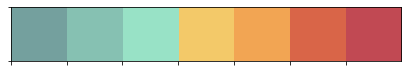

In [2]:
# Regular Imports
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import seaborn as sns
import math
import cv2
import pydicom
import os
import glob
import pickle as pkl
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
from skimage.transform import resize
import copy
import re
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Segmentation
import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

# Model imports
import tensorflow as tf 
from tensorflow.keras.layers import (
                                    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D,
                                    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate , Lambda
                                    )
from tensorflow.keras import Model
import tensorflow.keras.models as M
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
# import tensorflow.keras.applications as tfa
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split, KFold
import seaborn as sns


pd.set_option("display.max_columns", 100)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.palplot(sns.color_palette(custom_colors))

## 3. Tuned Hyperparameters
We define the number of -
* **epochs** : the number of times we loop through the dataset. 
* **batch_size**: how many training examples to feed into network before updating the weights and internal nodes
* **LR**: learning rate
* **MODEL_CLASS**:  allow us to define which efficientnet model we want to use
* **SAVE_BEST**: defined as true, to only save the model due to 'early stopping' implemented

In [3]:
EPOCHS = 40
BATCH_SIZE = 8
NFOLD = 5
LR = 0.003
SAVE_BEST = True
MODEL_CLASS = 'b1'
path = '../input/osic-pulmonary-fibrosis-progression'

## 4. Train-Test split
We create a test dataset with 20% of unique patients and their associated data; 80% for training. 
Duplicates are dropped as some patients have more than one recorded FVC value for each week. 

In [4]:
all_data = pd.read_csv(f'{path}/train.csv') 
all_data.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
unique_patients = all_data.Patient.unique()
train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train = all_data[all_data['Patient'].isin(train_ids)]
test = all_data[all_data['Patient'].isin(test_ids)]

## 5. Data Preprocessing
The original features of the data included Age, Smoking_Status, Sex, Weeks, Percent. However, we would like to transform the data, and include altered features. 

The features that will be fed into the model eventually include:
* baseline Age (numerical)
* baseline Percent (numerical)
* Gender (encoded)
* Smoking status (encoded)

Along with that, the numerical data is normalised and categorical variables are one-hot encoded.

In [5]:
def get_baseline_week(df):    
    # make a copy to not change original df    
    _df = df.copy()
    # ensure all Weeks values are INT and not accidentaly saved as string
    _df['Weeks'] = _df['Weeks'].astype(int)
    _df['min_week'] = _df['Weeks']
    _df["min_week"] = _df.groupby('Patient')['Weeks'].transform('min')
    _df['baselined_week'] = _df['Weeks'] - _df['min_week']
    
    return pd.DataFrame(_df)

In [6]:
train = get_baseline_week(train)
#train = get_baseline_FVC_new(train)
test = get_baseline_week(test)
#test = get_baseline_FVC_new(test)

In [7]:
# define which attributes shall not be transformed, are numeric or categorical
no_transform_attribs = ['Patient', 'Weeks', 'min_week', 'FVC']
num_attribs = ['Percent', 'Age']
cat_attribs = ['Sex', 'SmokingStatus']

In [8]:
from sklearn import preprocessing

num_attribs_scld = [s + '_scld' for s in num_attribs]

min_max_scaler = preprocessing.MinMaxScaler()
train[num_attribs_scld] = min_max_scaler.fit_transform(train[num_attribs])
test[num_attribs_scld] = min_max_scaler.transform(test[num_attribs])

In [9]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,-4,0,0.202489,0.789474
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,-4,9,0.181129,0.789474
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,-4,11,0.148772,0.789474
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,-4,13,0.166325,0.789474
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,-4,15,0.150464,0.789474


In [10]:
test.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
80,ID00023637202179104603099,-3,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947
81,ID00023637202179104603099,3,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947
82,ID00023637202179104603099,5,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947
83,ID00023637202179104603099,7,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947
84,ID00023637202179104603099,9,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947


Encoding our categorical variables. 
* Gender: Male: 0, Female: 1
* Smoking_Status: Never Smoked: [0,0], Ex-Smoker: [1,1], Currently Smokes: [0,1]


In [11]:
def get_tab_scaled(df): #getting scaled variables
    vector = [df.Percent_scld.values[0]] # only the first percent value is retained, so this forms the "base_percent"
    vector.append(df.Age_scld.values[0]) # only the first age value is retained, so this forms the "base age"
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    
    return np.array(vector)

We need to create the labels i.e y values for our dataset. We aim to predict the rate of FVC values deterioration, which would be the gradient of a linear regression model fit to every available patient. 

In [12]:
A = {} # Gradient of the linear regression of FVC against weeks 
TAB = {} # Initialize tabular data for each patient
P = [] # Patient IDs

# for all 140 train patients we compute the gradient 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values    
    weeks = sub.Weeks.values 
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab_scaled(sub)
    # TAB[p] = get_tab_unscaled(sub)
    P.append(p)

For each sliced ct scan, we need to resize into 512x512 pixel dimensions. 

In [13]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512, 512))

There are patients (labelled with BAD_IDs ( <span style = "color:red"> why are they bad_IDs maybe we need to explain that ? </span> )) that need to be removed from the training data. This class also transforms the dataframes into the required numpy arrays so that our data can be input into the neural network. 

In [14]:
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=BATCH_SIZE):
        self.keys = [k for k in keys if k not in self.BAD_ID] # all the patients in the keys  
        self.a = a # gradients found by fitting a linear regression model
        self.tab = tab # tabular data for patient specified in keys
        self.batch_size = batch_size
        
        self.train_data = {} # initialise a dictionary to contain all the images pertaining to one key: patient id 
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000 # 1000 batches per epoch
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size) # randomly chosen n patients for one batch  
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

## 7. Model Definition

In [15]:
def get_efficientnet(model, shape):
    '''
    From https://github.com/qubvel/efficientnet
    EfficientNet is a CNN architecture achieving state of the art accuracy.
    b0 is the simplest model, b7 is the most complex.
    '''
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False), # We use a b1 efficientnet
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape) # 512 x 512 input shape
    base = get_efficientnet(model_class, shape) # A b1 pre-trained efficientnet is used
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    out_tab = tf.keras.layers.GaussianNoise(0.2)(inp2) # add some noise to our data
    
    x2 = Concatenate()([x, out_tab]) 
    
    #### added ###
    den_1 = Dense(20)(x2) # linear layer with 50 output nodes
    den_1 = LeakyReLU(alpha=0.3)(den_1) # default alpha is 0.3
    den_2 = Dense(500)(den_1)
    den_2 = LeakyReLU(alpha=0.3)(den_2)
    bn_1 = BatchNormalization()(den_2)
    den_3 = Dense(100)(bn_1)
    
    x3 = Dropout(0.5)(den_3) # move the dropout layer to before the linear layers 
    
    # the linear layers here are akin to the final dense layer usually used in a "before concat" model
    out_1 = Dense(1)(x3)
    out_2 = Dense(1, activation='relu')(x3)
    y = out_1 + tf.keras.backend.cumsum(out_2, axis=1)
    
    model = Model([inp, inp2], y)
    return model

## 8. Model Training

We split the dataset into 5 folds for cross validation purposes. There is early stopping employed in the model and the loss function that we decided upon is RMSE = Root Mean Squared Error. It is a commonly used loss function in regression problems.  <span style = "color:red"> do we need to change mse in the code to rmse ? </span>

In [16]:
kf = KFold(n_splits=NFOLD, random_state=42,shuffle=False)
P = np.array(P)
subs = []
folds_history = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(P)):
    print('#####################')
    print('####### Fold %i ######'%fold)
    print('#####################')
    print('Training...')
    
    er = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-3,
        patience=8,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )

    cpt = tf.keras.callbacks.ModelCheckpoint(
        filepath='fold-%i.h5'%fold,
        monitor='val_loss', 
        verbose=1, 
        save_best_only=SAVE_BEST,
        mode='auto'
    )

    rlp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,
        patience=5, 
        verbose=1, 
        min_lr=1e-8
    )
    model = build_model(model_class=MODEL_CLASS)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mse") 
    history = model.fit_generator(IGenerator(keys=P[tr_idx], 
                                   a = A, 
                                   tab = TAB), 
                        steps_per_epoch = 32,
                        validation_data=IGenerator(keys=P[val_idx], 
                                   a = A, 
                                   tab = TAB),
                        validation_steps = 16, 
                        callbacks = [cpt, rlp], 
                        epochs=EPOCHS)
    folds_history.append(history.history)
    print('Training done!')

#####################
####### Fold 0 ######
#####################
Training...
Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 65.3370
Epoch 00001: val_loss improved from inf to 36609024.00000, saving model to fold-0.h5
32/32 [==============================] - 18s 561ms/step - loss: 65.3370 - val_loss: 36609024.0000
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 83.1371
Epoch 00002: val_loss improved from 36609024.00000 to 1811604.87500, saving model to fold-0.h5
32/32 [==============================] - 16s 489ms/step - loss: 83.1371 - val_loss: 1811604.8750
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 79.6172
Epoch 00003: val_loss did not improve from 1811604.87500
32/32 [==============================] - 15s 455ms/step - loss: 79.6172 - val_loss: 388879904.0000
Epoch 4/40
32/32 [==============================] - ETA: 0s - loss: 42.2223
Epoch 00004: val_loss improved from 1811604.87500 to 8744.35352, saving model to fold-0

Epoch 35/40
32/32 [==============================] - ETA: 0s - loss: 26.6615
Epoch 00035: val_loss did not improve from 30.75502
32/32 [==============================] - 14s 445ms/step - loss: 26.6615 - val_loss: 48.2619
Epoch 36/40
32/32 [==============================] - ETA: 0s - loss: 37.5496
Epoch 00036: val_loss did not improve from 30.75502
32/32 [==============================] - 14s 440ms/step - loss: 37.5496 - val_loss: 42.6087
Epoch 37/40
32/32 [==============================] - ETA: 0s - loss: 28.8148
Epoch 00037: val_loss did not improve from 30.75502

Epoch 00037: ReduceLROnPlateau reducing learning rate to 9.375000081490725e-05.
32/32 [==============================] - 14s 442ms/step - loss: 28.8148 - val_loss: 31.4820
Epoch 38/40
32/32 [==============================] - ETA: 0s - loss: 26.6187
Epoch 00038: val_loss did not improve from 30.75502
32/32 [==============================] - 14s 443ms/step - loss: 26.6187 - val_loss: 48.5195
Epoch 39/40
32/32 [================

32/32 [==============================] - ETA: 0s - loss: 32.9484
Epoch 00029: val_loss did not improve from 16.70410
32/32 [==============================] - 14s 435ms/step - loss: 32.9484 - val_loss: 19.1051
Epoch 30/40
32/32 [==============================] - ETA: 0s - loss: 44.0718
Epoch 00030: val_loss did not improve from 16.70410
32/32 [==============================] - 14s 445ms/step - loss: 44.0718 - val_loss: 21.7917
Epoch 31/40
32/32 [==============================] - ETA: 0s - loss: 31.6604
Epoch 00031: val_loss did not improve from 16.70410
32/32 [==============================] - 14s 445ms/step - loss: 31.6604 - val_loss: 22.9764
Epoch 32/40
32/32 [==============================] - ETA: 0s - loss: 39.5107
Epoch 00032: val_loss did not improve from 16.70410

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0001875000016298145.
32/32 [==============================] - 14s 441ms/step - loss: 39.5107 - val_loss: 20.6386
Epoch 33/40
32/32 [============================

32/32 [==============================] - ETA: 0s - loss: 40.4749
Epoch 00023: val_loss improved from 30.93038 to 28.64675, saving model to fold-2.h5
32/32 [==============================] - 15s 472ms/step - loss: 40.4749 - val_loss: 28.6467
Epoch 24/40
32/32 [==============================] - ETA: 0s - loss: 36.8286
Epoch 00024: val_loss did not improve from 28.64675
32/32 [==============================] - 14s 440ms/step - loss: 36.8286 - val_loss: 29.8146
Epoch 25/40
32/32 [==============================] - ETA: 0s - loss: 34.9751
Epoch 00025: val_loss did not improve from 28.64675
32/32 [==============================] - 14s 444ms/step - loss: 34.9751 - val_loss: 34.3410
Epoch 26/40
32/32 [==============================] - ETA: 0s - loss: 31.7415
Epoch 00026: val_loss improved from 28.64675 to 23.55861, saving model to fold-2.h5
32/32 [==============================] - 15s 472ms/step - loss: 31.7415 - val_loss: 23.5586
Epoch 27/40
32/32 [==============================] - ETA: 0s - l

Epoch 18/40
32/32 [==============================] - ETA: 0s - loss: 35.6037
Epoch 00018: val_loss did not improve from 22.27123
32/32 [==============================] - 14s 445ms/step - loss: 35.6037 - val_loss: 45.4256
Epoch 19/40
32/32 [==============================] - ETA: 0s - loss: 29.5910
Epoch 00019: val_loss did not improve from 22.27123

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.000750000006519258.
32/32 [==============================] - 14s 441ms/step - loss: 29.5910 - val_loss: 31.1493
Epoch 20/40
32/32 [==============================] - ETA: 0s - loss: 37.2329
Epoch 00020: val_loss did not improve from 22.27123
32/32 [==============================] - 14s 437ms/step - loss: 37.2329 - val_loss: 33.6486
Epoch 21/40
32/32 [==============================] - ETA: 0s - loss: 34.6175
Epoch 00021: val_loss did not improve from 22.27123
32/32 [==============================] - 14s 452ms/step - loss: 34.6175 - val_loss: 32.5958
Epoch 22/40
32/32 [=================

32/32 [==============================] - ETA: 0s - loss: 45.0101
Epoch 00012: val_loss did not improve from 29.09500

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
32/32 [==============================] - 14s 439ms/step - loss: 45.0101 - val_loss: 34.3495
Epoch 13/40
32/32 [==============================] - ETA: 0s - loss: 31.0014
Epoch 00013: val_loss did not improve from 29.09500
32/32 [==============================] - 15s 454ms/step - loss: 31.0014 - val_loss: 46.8030
Epoch 14/40
32/32 [==============================] - ETA: 0s - loss: 30.4583
Epoch 00014: val_loss did not improve from 29.09500
32/32 [==============================] - 14s 449ms/step - loss: 30.4583 - val_loss: 31.1683
Epoch 15/40
32/32 [==============================] - ETA: 0s - loss: 27.6079
Epoch 00015: val_loss improved from 29.09500 to 28.07808, saving model to fold-4.h5
32/32 [==============================] - 15s 472ms/step - loss: 27.6079 - val_loss: 28.0781
Epoch 16/40
32/3

## 9. Validation Loss examination

In [33]:
min_array = []
for i in range(5):
    min_array.append(min(folds_history[i]['val_loss']))
    print(i, min(folds_history[i]['val_loss']))
print(min(min_array))

0 30.755016326904297
1 16.704097747802734
2 23.55861473083496
3 22.27122688293457
4 23.309782028198242
16.704097747802734


In [34]:
# We pick the best model (weights) based on cross validation score.
if SAVE_BEST:
    mean_val_loss = np.mean([np.min(h['val_loss']) for h in folds_history])
else:
    mean_val_loss = np.mean([h['val_loss'][-1] for h in folds_history])
print('Our mean CV MAE is: ' + str(mean_val_loss))

Our mean CV MAE is: 23.319747543334962


min_fold finds out which fold gives the least validation loss

In [35]:
min_fold = np.argmin([np.min(h['val_loss']) for h in folds_history])

In [36]:
min_fold

1

^print what is the fold that gives min loss, keep a record below 

In [37]:
################################
# min_fold = 1 #change accordingly
################################
#uncomment for using notebook

1. download the weights from the output and save to zip file and upload them 
2. Restart kernel at this point for fitting weights from best fold to model in model building

building model for prediction

## 10. Model for Test Data

In [38]:
def build_pred_model(shape=(512, 512, 1), model_class=None, fold=None):
    inp = Input(shape=shape) # 512 x 512 input shape
    base = get_efficientnet(model_class, shape) # A b1 pre-trained efficientnet is used
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    
    inp2 = Input(shape=(4,))
    out_tab = tf.keras.layers.GaussianNoise(0.2)(inp2) # add some noise to our data
    
    x2 = Concatenate()([x, out_tab]) 
    
    #### added ###
    den_1 = Dense(20)(x2) # linear layer with 50 output nodes
    den_1 = LeakyReLU(alpha=0.3)(den_1) # default alpha is 0.3
    den_2 = Dense(500)(den_1)
    den_2 = LeakyReLU(alpha=0.3)(den_2)
    bn_1 = BatchNormalization()(den_2)
    den_3 = Dense(100)(bn_1)
    
    x3 = Dropout(0.5)(den_3) # move the dropout layer to before the linear layers 
    
    # the linear layers here are akin to the final dense layer usually used in a "before concat" model
    out_1 = Dense(1)(x3)
    out_2 = Dense(1, activation='relu')(x3)
    y = out_1 + tf.keras.backend.cumsum(out_2, axis=1)
    
    model = Model([inp, inp2], y)
    
    # Take from kaggle  working output
    weights = [w for w in os.listdir('./') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    model.load_weights('./' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    
    #take weights from uploaded weights
    #uncomment when using notebook, instead of when committing notebook
    #weights = [w for w in os.listdir('../input/scaled-weights-genderagepercentsmoker/') if str(fold) in w][0] #use dir of './' if using training above, else can just use my trained weights in input
    #model.load_weights('../input/scaled-weights-genderagepercentsmoker/' + weights) #use dir of './' if using training above, else can just use my trained weights in input
    return model
#models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]
#uncomment the above to build model from the weights trained above, else can use the below code for building model
models = [build_pred_model(shape=(512, 512, 1), model_class='b1', fold=min_fold)]

In [39]:
subs = []
q = 0.5
weeks = list(range(-12, 134))
predictions = []
for model in models:
    metric = []
    
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15: # what is this? only certain slices are being extracted for patients?
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/{i}')) 
                tab.append(get_tab_scaled(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        print(len(test[test.Patient == p])) # number of fvc values to predict for every week
        tab = np.array(tab) 
        print("number of patient data is: ", len(tab))
        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) # Predict from all image data and tabular data.
        a = np.quantile(_a, q) # Get the value at the 50th percentile
        
        A_test[p] = a
        print("number of patient FVC data is: ", len(test.FVC.values[test.Patient == p])) # number of times patient takes
        #######################################################################################################################################
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p] #to find the y intercept   #
        #######################################################################################################################################
        print("B_test[p] is: ", B_test[p])
        #B_test is actually to find the intercept
        
        #P_test[p] = test.Percent_scld.values[test.Patient == p] 
        #print("P_test[p] is: ", P_test[p])
        #WEEK[p] = test.baselined_week_scld.values[test.Patient == p]
        #print("WEEK[p] is: ", WEEK[p])
    
    for p in test.Patient.unique():
        for w in weeks:
            patient_prediction = {}
            fvc = A_test[p] * w + B_test[p]  #y = mx + c, A_test[p] = gradient of progression for patient p, w = week_num, B_test[p] is the calculated y_intercept
            print("fvc is: ", fvc)
            patient_prediction = {
                'Week': w,
                'Patient': p,
                'FVC': np.sum(fvc)/len(fvc)
            }
            predictions.append(patient_prediction)
print('done!')

9
number of patient data is:  17
number of patient FVC data is:  9
B_test[p] is:  [1521.53927422 1382.46072578 1385.10120964 1498.7416935  1724.38217735
 1533.30362892 1467.14653206 1491.9894352  1671.11330605]
9
number of patient data is:  233
number of patient FVC data is:  9
B_test[p] is:  [2529.84757233 2862.48883438 2827.13009644 2783.77135849 2997.87451363
 2672.33640671 2747.18397903 2784.85218239 2696.1616478 ]
9
number of patient data is:  373
number of patient FVC data is:  9
B_test[p] is:  [2772.41749239 2651.45544624 2690.53135395 2732.60726166 2756.68316936
 2883.91089249 2536.36633873 2392.85973883 2534.46700048]
9
number of patient data is:  225
number of patient FVC data is:  9
B_test[p] is:  [3974.92617512 3962.85235023 3859.31543779 4069.95749617 4091.59955454
 3946.70470047 4019.5570507  4114.23043013 4199.72483873]
6
number of patient data is:  67
number of patient FVC data is:  6
B_test[p] is:  [3322.64226437 3254.28452873 3398.9267931  3167.56905746 3284.21132183


fvc is:  [2332.28052235 2211.3184762  2250.39438391 2292.47029161 2316.54619932
 2443.77392244 2096.22936869 1952.72276878 2094.33003044]
fvc is:  [2328.24256849 2207.28052235 2246.35643005 2288.43233776 2312.50824547
 2439.73596859 2092.19141483 1948.68481493 2090.29207659]
fvc is:  [2324.20461464 2203.24256849 2242.3184762  2284.39438391 2308.47029161
 2435.69801474 2088.15346098 1944.64686108 2086.25412273]
fvc is:  [2320.16666079 2199.20461464 2238.28052235 2280.35643005 2304.43233776
 2431.66006088 2084.11550713 1940.60890722 2082.21616888]
fvc is:  [2316.12870693 2195.16666079 2234.24256849 2276.3184762  2300.39438391
 2427.62210703 2080.07755327 1936.57095337 2078.17821503]
fvc is:  [2312.09075308 2191.12870693 2230.20461464 2272.28052235 2296.35643005
 2423.58415318 2076.03959942 1932.53299952 2074.14026117]
fvc is:  [2308.05279922 2187.09075308 2226.16666079 2268.24256849 2292.3184762
 2419.54619932 2072.00164557 1928.49504566 2070.10230732]
fvc is:  [2304.01484537 2183.052799

 3171.09736204]
fvc is:  [3337.10566092 3268.74792528 3413.39018965 3182.03245401 3298.67471838
 3166.27622986]
fvc is:  [3332.28452873 3263.9267931  3408.56905746 3177.21132183 3293.8535862
 3161.45509768]
fvc is:  [3327.46339655 3259.10566092 3403.74792528 3172.39018965 3289.03245401
 3156.63396549]
fvc is:  [3322.64226437 3254.28452873 3398.9267931  3167.56905746 3284.21132183
 3151.81283331]
fvc is:  [3317.82113218 3249.46339655 3394.10566092 3162.74792528 3279.39018965
 3146.99170113]
fvc is:  [3313.         3244.64226437 3389.28452873 3157.9267931  3274.56905746
 3142.17056894]
fvc is:  [3308.17886782 3239.82113218 3384.46339655 3153.10566092 3269.74792528
 3137.34943676]
fvc is:  [3303.35773563 3235.         3379.64226437 3148.28452873 3264.9267931
 3132.52830458]
fvc is:  [3298.53660345 3230.17886782 3374.82113218 3143.46339655 3260.10566092
 3127.70717239]
fvc is:  [3293.71547127 3225.35773563 3370.         3138.64226437 3255.28452873
 3122.88604021]
fvc is:  [3288.89433908 32

fvc is:  [ 897.77835083  955.4172287   984.05610657  987.97274017 1018.80600739
 1059.27815247 1109.75029755]
fvc is:  [ 892.9589119   950.59778976  979.23666763  983.15330124 1013.98656845
 1054.45871353 1104.93085861]
fvc is:  [ 888.13947296  945.77835083  974.4172287   978.3338623  1009.16712952
 1049.6392746  1100.11141968]
fvc is:  [ 883.32003403  940.9589119   969.59778976  973.51442337 1004.34769058
 1044.81983566 1095.29198074]
fvc is:  [ 878.50059509  936.13947296  964.77835083  968.69498444  999.52825165
 1040.00039673 1090.47254181]
fvc is:  [ 873.68115616  931.32003403  959.9589119   963.8755455   994.70881271
 1035.18095779 1085.65310287]
fvc is:  [ 868.86171722  926.50059509  955.13947296  959.05610657  989.88937378
 1030.36151886 1080.83366394]
fvc is:  [ 864.04227829  921.68115616  950.32003403  954.23666763  985.06993484
 1025.54207993 1076.01422501]
fvc is:  [ 859.22283936  916.86171722  945.50059509  949.4172287   980.25049591
 1020.72264099 1071.19478607]
fvc is:  [

fvc is:  [1317.8500576  1232.31945801 1225.14259148 1323.61199188 1330.43512535
 1372.19705963 1271.25152779 1146.48286247 1122.29926491]
fvc is:  [1313.02692413 1227.49632454 1220.31945801 1318.78885841 1325.61199188
 1367.37392616 1266.42839432 1141.659729   1117.47613144]
fvc is:  [1308.20379066 1222.67319107 1215.49632454 1313.96572495 1320.78885841
 1362.55079269 1261.60526085 1136.83659554 1112.65299797]
fvc is:  [1303.3806572  1217.8500576  1210.67319107 1309.14259148 1315.96572495
 1357.72765923 1256.78212738 1132.01346207 1107.8298645 ]
fvc is:  [1298.55752373 1213.02692413 1205.8500576  1304.31945801 1311.14259148
 1352.90452576 1251.95899391 1127.1903286  1103.00673103]
fvc is:  [1293.73439026 1208.20379066 1201.02692413 1299.49632454 1306.31945801
 1348.08139229 1247.13586044 1122.36719513 1098.18359756]
fvc is:  [1288.91125679 1203.3806572  1196.20379066 1294.67319107 1301.49632454
 1343.25825882 1242.31272697 1117.54406166 1093.3604641 ]
fvc is:  [1284.08812332 1198.55752

fvc is:  [3078.40335369 3034.22422981 3145.86598206 3312.5077343  3197.14948654
 3362.07474327 3528.10438061 3464.77577019 3559.73066425]
fvc is:  [3073.58247757 3029.40335369 3141.04510593 3307.68685818 3192.32861042
 3357.25386715 3523.28350449 3459.95489407 3554.90978813]
fvc is:  [3068.76160145 3024.58247757 3136.22422981 3302.86598206 3187.5077343
 3352.43299103 3518.46262836 3455.13401794 3550.08891201]
fvc is:  [3063.94072533 3019.76160145 3131.40335369 3298.04510593 3182.68685818
 3347.61211491 3513.64175224 3450.31314182 3545.26803589]
fvc is:  [3059.11984921 3014.94072533 3126.58247757 3293.22422981 3177.86598206
 3342.79123878 3508.82087612 3445.4922657  3540.44715977]
fvc is:  [3054.29897308 3010.11984921 3121.76160145 3288.40335369 3173.04510593
 3337.97036266 3504.         3440.67138958 3535.62628365]
fvc is:  [3049.47809696 3005.29897308 3116.94072533 3283.58247757 3168.22422981
 3333.14948654 3499.17912388 3435.85051346 3530.80540752]
fvc is:  [3044.65722084 3000.478096

fvc is:  [2135.43442369 2101.99226475 2118.10794687 2166.78147006 1997.89715219
 1906.6863575  1908.38045025 1664.63238406]
fvc is:  [2130.87658262 2097.43442369 2113.55010581 2162.223629   1993.33931112
 1902.12851644 1903.82260919 1660.074543  ]
fvc is:  [2126.31874156 2092.87658262 2108.99226475 2157.66578794 1988.78147006
 1897.57067537 1899.26476812 1655.51670194]
fvc is:  [2121.7609005  2088.31874156 2104.43442369 2153.10794687 1984.223629
 1893.01283431 1894.70692706 1650.95886087]
fvc is:  [2117.20305943 2083.7609005  2099.87658262 2148.55010581 1979.66578794
 1888.45499325 1890.149086   1646.40101981]
fvc is:  [2112.64521837 2079.20305943 2095.31874156 2143.99226475 1975.10794687
 1883.89715219 1885.59124494 1641.84317875]
fvc is:  [2108.08737731 2074.64521837 2090.7609005  2139.43442369 1970.55010581
 1879.33931112 1881.03340387 1637.28533769]
fvc is:  [2103.52953625 2070.08737731 2086.20305943 2134.87658262 1965.99226475
 1874.78147006 1876.47556281 1632.72749662]
fvc is:  [

fvc is:  [2261.98942089 2185.8118782  2224.45679283 2354.10170746 2339.74662209
 2328.68136597 2302.55085373 2288.24279881 2275.57965851 2129.04703045]
fvc is:  [2257.16696358 2180.98942089 2219.63433552 2349.27925014 2334.92416477
 2323.85890865 2297.72839642 2283.42034149 2270.75720119 2124.22457314]
fvc is:  [2252.34450626 2176.16696358 2214.8118782  2344.45679283 2330.10170746
 2319.03645134 2292.9059391  2278.59788418 2265.93474388 2119.40211582]
fvc is:  [2247.52204895 2171.34450626 2209.98942089 2339.63433552 2325.27925014
 2314.21399403 2288.08348179 2273.77542686 2261.11228657 2114.57965851]
fvc is:  [2242.69959164 2166.52204895 2205.16696358 2334.8118782  2320.45679283
 2309.39153671 2283.26102448 2268.95296955 2256.28982925 2109.75720119]
fvc is:  [2237.87713432 2161.69959164 2200.34450626 2329.98942089 2315.63433552
 2304.5690794  2278.43856716 2264.13051224 2251.46737194 2104.93474388]
fvc is:  [2233.05467701 2156.87713432 2195.52204895 2325.16696358 2310.8118782
 2299.746

 1763.56159377 1757.60869503 1764.47826004 1859.63768005]
fvc is:  [1710.75724626 1834.04710126 1835.69202876 1843.33695626 1748.98188376
 1758.73913002 1752.78623128 1759.65579629 1854.8152163 ]
fvc is:  [1705.93478251 1829.22463751 1830.86956501 1838.51449251 1744.15942001
 1753.91666627 1747.96376753 1754.83333254 1849.99275255]
fvc is:  [1701.11231875 1824.40217376 1826.04710126 1833.69202876 1739.33695626
 1749.09420252 1743.14130378 1750.01086879 1845.1702888 ]
fvc is:  [1696.289855   1819.57971001 1821.22463751 1828.86956501 1734.51449251
 1744.27173877 1738.31884003 1745.18840504 1840.34782505]
fvc is:  [1691.46739125 1814.75724626 1816.40217376 1824.04710126 1729.69202876
 1739.44927502 1733.49637628 1740.36594129 1835.5253613 ]
fvc is:  [1686.6449275  1809.93478251 1811.57971001 1819.22463751 1724.86956501
 1734.62681127 1728.67391253 1735.54347754 1830.70289755]
fvc is:  [1681.82246375 1805.11231875 1806.75724626 1814.40217376 1720.04710126
 1729.80434752 1723.85144877 1730.

fvc is:  [2299.92720056 2343.44037604 2481.07525766 2414.95355153 2325.71013927
 2371.97990251 2386.51942897 2463.05895543 2475.98995125]
fvc is:  [2297.04890668 2340.56208217 2478.19696379 2412.07525766 2322.8318454
 2369.10160863 2383.6411351  2460.18066156 2473.11165738]
fvc is:  [2294.17061281 2337.6837883  2475.31866992 2409.19696379 2319.95355153
 2366.22331476 2380.76284122 2457.30236769 2470.23336351]
fvc is:  [2291.29231894 2334.80549443 2472.44037604 2406.31866992 2317.07525766
 2363.34502089 2377.88454735 2454.42407382 2467.35506964]
fvc is:  [2288.41402507 2331.92720056 2469.56208217 2403.44037604 2314.19696379
 2360.46672702 2375.00625348 2451.54577994 2464.47677577]
fvc is:  [2285.5357312  2329.04890668 2466.6837883  2400.56208217 2311.31866992
 2357.58843315 2372.12795961 2448.66748607 2461.59848189]
fvc is:  [2282.65743732 2326.17061281 2463.80549443 2397.6837883  2308.44037604
 2354.71013927 2369.24966574 2445.7891922  2458.72018802]
fvc is:  [2279.77914345 2323.292318

 4030.94807267 4210.43472075 4037.45994425 3842.76706719]
fvc is:  [3788.17952514 3761.28189945 3949.74332404 4168.5637989  4098.20474863
 4026.12759781 4205.61424589 4032.63946939 3837.94659233]
fvc is:  [3783.35905027 3756.46142459 3944.92284918 4163.74332404 4093.38427377
 4021.30712295 4200.79377103 4027.81899452 3833.12611747]
fvc is:  [3778.53857541 3751.64094973 3940.10237432 4158.92284918 4088.5637989
 4016.48664808 4195.97329617 4022.99851966 3828.3056426 ]
fvc is:  [3773.71810055 3746.82047486 3935.28189945 4154.10237432 4083.74332404
 4011.66617322 4191.1528213  4018.1780448  3823.48516774]
fvc is:  [3768.89762568 3742.         3930.46142459 4149.28189945 4078.92284918
 4006.84569836 4186.33234644 4013.35756993 3818.66469288]
fvc is:  [3764.07715082 3737.17952514 3925.64094973 4144.46142459 4074.10237432
 4002.02522349 4181.51187158 4008.53709507 3813.84421802]
fvc is:  [3759.25667596 3732.35905027 3920.82047486 4139.64094973 4069.28189945
 3997.20474863 4176.69139671 4003.7

 1732.55716705 1811.42286682 1672.28856659 1669.26497459]
fvc is:  [1530.29219246 1769.86932564 1724.51360893 1686.33575058 1652.80217552
 1727.73502541 1806.60072517 1667.46642494 1664.44283295]
fvc is:  [1525.47005081 1765.04718399 1719.69146729 1681.51360893 1647.98003387
 1722.91288376 1801.77858353 1662.64428329 1659.6206913 ]
fvc is:  [1520.64790916 1760.22504234 1714.86932564 1676.69146729 1643.15789223
 1718.09074211 1796.95644188 1657.82214165 1654.79854965]
fvc is:  [1515.82576752 1755.4029007  1710.04718399 1671.86932564 1638.33575058
 1713.26860046 1792.13430023 1653.         1649.976408  ]
fvc is:  [1511.00362587 1750.58075905 1705.22504234 1667.04718399 1633.51360893
 1708.44645882 1787.31215858 1648.17785835 1645.15426636]
fvc is:  [1506.18148422 1745.7586174  1700.4029007  1662.22504234 1628.69146729
 1703.62431717 1782.49001694 1643.35571671 1640.33212471]
fvc is:  [1501.35934258 1740.93647575 1695.58075905 1657.4029007  1623.86932564
 1698.80217552 1777.66787529 1638.

fvc is:  [2302.62420583 2291.22888708 2359.43824959 2385.64761209 2351.8569746
 2360.48506212 2377.74123716 2477.9974122  2464.06763101]
fvc is:  [2298.01952457 2286.62420583 2354.83356833 2381.04293084 2347.25229335
 2355.88038087 2373.13655591 2473.39273095 2459.46294975]
fvc is:  [2293.41484332 2282.01952457 2350.22888708 2376.43824959 2342.64761209
 2351.27569962 2368.53187466 2468.7880497  2454.8582685 ]
fvc is:  [2288.81016207 2277.41484332 2345.62420583 2371.83356833 2338.04293084
 2346.67101836 2363.9271934  2464.18336844 2450.25358725]
fvc is:  [2284.20548081 2272.81016207 2341.01952457 2367.22888708 2333.43824959
 2342.06633711 2359.32251215 2459.57868719 2445.64890599]
fvc is:  [2279.60079956 2268.20548081 2336.41484332 2362.62420583 2328.83356833
 2337.46165586 2354.7178309  2454.97400594 2441.04422474]
fvc is:  [2274.99611831 2263.60079956 2331.81016207 2358.01952457 2324.22888708
 2332.8569746  2350.11314964 2450.36932468 2436.43954349]
fvc is:  [2270.39143705 2258.996118

 1689.99066925 1865.65309525 1900.49533463]
fvc is:  [1629.50805664 1663.32824326 1723.96861649 1959.42917633 1789.24936295
 1685.17048264 1860.83290863 1895.67514801]
fvc is:  [1624.68787003 1658.50805664 1719.14842987 1954.60898972 1784.42917633
 1680.35029602 1856.01272202 1890.8549614 ]
fvc is:  [1619.86768341 1653.68787003 1714.32824326 1949.7888031  1779.60898972
 1675.53010941 1851.1925354  1886.03477478]
fvc is:  [1615.0474968  1648.86768341 1709.50805664 1944.96861649 1774.7888031
 1670.70992279 1846.37234879 1881.21458817]
fvc is:  [1610.22731018 1644.0474968  1704.68787003 1940.14842987 1769.96861649
 1665.88973618 1841.55216217 1876.39440155]
fvc is:  [1605.40712357 1639.22731018 1699.86768341 1935.32824326 1765.14842987
 1661.06954956 1836.73197556 1871.57421494]
fvc is:  [1600.58693695 1634.40712357 1695.0474968  1930.50805664 1760.32824326
 1656.24936295 1831.91178894 1866.75402832]
fvc is:  [1595.76675034 1629.58693695 1690.22731018 1925.68787003 1755.50805664
 1651.429

 2154.49742031 2181.41970348 1748.34198666 1983.23836422]
fvc is:  [2181.84456635 2013.33161354 2251.81866074 2294.30570793 2179.79275513
 2150.25389671 2177.17617989 1744.09846306 1978.99484062]
fvc is:  [2177.60104275 2009.08808994 2247.57513714 2290.06218433 2175.54923153
 2146.01037312 2172.93265629 1739.85493946 1974.75131702]
fvc is:  [2173.35751915 2004.84456635 2243.33161354 2285.81866074 2171.30570793
 2141.76684952 2168.68913269 1735.61141586 1970.50779343]
fvc is:  [2169.11399555 2000.60104275 2239.08808994 2281.57513714 2167.06218433
 2137.52332592 2164.44560909 1731.36789227 1966.26426983]
fvc is:  [2164.87047195 1996.35751915 2234.84456635 2277.33161354 2162.81866074
 2133.27980232 2160.20208549 1727.12436867 1962.02074623]
fvc is:  [2160.62694836 1992.11399555 2230.60104275 2273.08808994 2158.57513714
 2129.03627872 2155.9585619  1722.88084507 1957.77722263]
fvc is:  [2156.38342476 1987.87047195 2226.35751915 2268.84456635 2154.33161354
 2124.79275513 2151.7150383  1718.

 1549.87184906 1577.74729919 1725.62274933 1766.967062  ]
fvc is:  [1482.70458221 1386.17344475 1498.8193531  1518.46526146 1670.11116982
 1545.04889488 1572.92434502 1720.79979515 1762.14410782]
fvc is:  [1477.88162804 1381.35049057 1493.99639893 1513.64230728 1665.28821564
 1540.2259407  1568.10139084 1715.97684097 1757.32115364]
fvc is:  [1473.05867386 1376.52753639 1489.17344475 1508.8193531  1660.46526146
 1535.40298653 1563.27843666 1711.1538868  1752.49819946]
fvc is:  [1468.23571968 1371.70458221 1484.35049057 1503.99639893 1655.64230728
 1530.58003235 1558.45548248 1706.33093262 1747.67524529]
fvc is:  [1463.4127655  1366.88162804 1479.52753639 1499.17344475 1650.8193531
 1525.75707817 1553.63252831 1701.50797844 1742.85229111]
fvc is:  [1458.58981133 1362.05867386 1474.70458221 1494.35049057 1645.99639893
 1520.93412399 1548.80957413 1696.68502426 1738.02933693]
fvc is:  [1453.76685715 1357.23571968 1469.88162804 1489.52753639 1641.17344475
 1516.11116982 1543.98661995 1691.8

fvc is:  [2943.46140385 3034.92131424 3089.5612545  3010.20119476 2982.84113503
 2951.76095581 2742.42056751 2733.08017921 2921.55976105]
fvc is:  [2938.64143372 3030.10134411 3084.74128437 3005.38122463 2978.02116489
 2946.94098568 2737.60059738 2728.26020908 2916.73979092]
fvc is:  [2933.82146358 3025.28137398 3079.92131424 3000.5612545  2973.20119476
 2942.12101555 2732.78062725 2723.44023895 2911.91982079]
fvc is:  [2929.00149345 3020.46140385 3075.10134411 2995.74128437 2968.38122463
 2937.30104542 2727.96065712 2718.62026882 2907.09985065]
fvc is:  [2924.18152332 3015.64143372 3070.28137398 2990.92131424 2963.5612545
 2932.48107529 2723.14068699 2713.80029869 2902.27988052]
fvc is:  [2919.36155319 3010.82146358 3065.46140385 2986.10134411 2958.74128437
 2927.66110516 2718.32071686 2708.98032856 2897.45991039]
fvc is:  [2914.54158306 3006.00149345 3060.64143372 2981.28137398 2953.92131424
 2922.84113503 2713.50074673 2704.16035843 2892.63994026]
fvc is:  [2909.72161293 3001.181523

fvc is:  [1814.71873283 1793.64316559 1859.10538197 1798.74685955 1774.38833714
 1814.31276989 1779.1616354  1677.01050091 1976.14232159]
fvc is:  [1809.89799404 1788.8224268  1854.28464317 1793.92612076 1769.56759834
 1809.4920311  1774.34089661 1672.18976212 1971.32158279]
fvc is:  [1805.07725525 1784.001688   1849.46390438 1789.10538197 1764.74685955
 1804.6712923  1769.52015781 1667.36902332 1966.500844  ]
fvc is:  [1800.25651646 1779.18094921 1844.64316559 1784.28464317 1759.92612076
 1799.85055351 1764.69941902 1662.54828453 1961.68010521]
fvc is:  [1795.43577766 1774.36021042 1839.8224268  1779.46390438 1755.10538197
 1795.02981472 1759.87868023 1657.72754574 1956.85936642]
fvc is:  [1790.61503887 1769.53947163 1835.001688   1774.64316559 1750.28464317
 1790.20907593 1755.05794144 1652.90680695 1952.03862762]
fvc is:  [1785.79430008 1764.71873283 1830.18094921 1769.8224268  1745.46390438
 1785.38833714 1750.23720264 1648.08606815 1947.21788883]
fvc is:  [1780.97356129 1759.89799

fvc is:  [2149.03269935 2031.67591119 2151.31912303 2105.96233487 1996.60554671
 2043.53518224 2039.39445329 1931.25372434 1986.39941907]
fvc is:  [2144.21109343 2026.85430527 2146.49751711 2101.14072895 1991.78394079
 2038.71357632 2034.57284737 1926.43211842 1981.57781315]
fvc is:  [2139.3894875  2022.03269935 2141.67591119 2096.31912303 1986.96233487
 2033.8919704  2029.75124145 1921.6105125  1976.75620723]
fvc is:  [2134.56788158 2017.21109343 2136.85430527 2091.49751711 1982.14072895
 2029.07036448 2024.92963552 1916.78890657 1971.93460131]
fvc is:  [2129.74627566 2012.3894875  2132.03269935 2086.67591119 1977.31912303
 2024.24875855 2020.1080296  1911.96730065 1967.11299539]
fvc is:  [2124.92466974 2007.56788158 2127.21109343 2081.85430527 1972.49751711
 2019.42715263 2015.28642368 1907.14569473 1962.29138947]
fvc is:  [2120.10306382 2002.74627566 2122.3894875  2077.03269935 1967.67591119
 2014.60554671 2010.46481776 1902.32408881 1957.46978354]
fvc is:  [2115.2814579  1997.92466

fvc is:  [2204.37219572 2615.47846341 2241.12097049 2491.76347756 2250.40598464
 1968.33350587 1896.18854833 1948.86484432 1467.36239386]
fvc is:  [2199.55094218 2610.65720987 2236.29971695 2486.94222403 2245.5847311
 1963.51225233 1891.36729479 1944.04359078 1462.54114032]
fvc is:  [2194.72968864 2605.83595634 2231.47846341 2482.12097049 2240.76347756
 1958.69099879 1886.54604125 1939.22233725 1457.71988678]
fvc is:  [2189.90843511 2601.0147028  2226.65720987 2477.29971695 2235.94222403
 1953.86974525 1881.72478771 1934.40108371 1452.89863324]
fvc is:  [2185.08718157 2596.19344926 2221.83595634 2472.47846341 2231.12097049
 1949.04849172 1876.90353417 1929.57983017 1448.0773797 ]
fvc is:  [2180.26592803 2591.37219572 2217.0147028  2467.65720987 2226.29971695
 1944.22723818 1872.08228064 1924.75857663 1443.25612617]
fvc is:  [2175.44467449 2586.55094218 2212.19344926 2462.83595634 2221.47846341
 1939.40598464 1867.2610271  1919.93732309 1438.43487263]
fvc is:  [2170.62342095 2581.729688

In [40]:
predictions

[{'Week': -12,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1577.3737901051838},
 {'Week': -11,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1572.5535481770833},
 {'Week': -10,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1567.7333062489827},
 {'Week': -9,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1562.913064320882},
 {'Week': -8,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1558.0928223927815},
 {'Week': -7,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1553.272580464681},
 {'Week': -6,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1548.4523385365803},
 {'Week': -5,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1543.6320966084797},
 {'Week': -4,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1538.8118546803792},
 {'Week': -3,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1533.9916127522786},
 {'Week': -2,
  'Patient': 'ID00023637202179104603099',
  'FVC': 1529.171370824178},
 {'Week': -1,
  'Patient': 'ID00023637202179104603099'

In [41]:
# GET RESULTS INTO A DATAFRAME 
predictions_df = pd.DataFrame(predictions)
# predictions_df.to_csv("test_predictions_GAPS_scaled.csv")

pred_patients are unique patientID of patients in the predictions 

In [42]:
pred_patients  = predictions_df.Patient.unique()

In [43]:
predictions_df.rename(columns = {'Week': 'Weeks'}, inplace = True)

In [44]:
merged_data = pd.merge(predictions_df, test, on = ['Patient', 'Weeks'], how = 'inner')

In [29]:
merged_data 

,Weeks,Patient,FVC_x,FVC_y,Percent,Age,Sex,SmokingStatus,min_week,baselined_week,Percent_scld,Age_scld
0,-3,ID00023637202179104603099,1533.991613,1536,65.306122,71,Female,Ex-smoker,-3,0,0.261761,0.578947
1,3,ID00023637202179104603099,1505.070161,1368,58.163265,71,Female,Ex-smoker,-3,6,0.201730,0.578947
2,5,ID00023637202179104603099,1495.429677,1361,57.865646,71,Female,Ex-smoker,-3,8,0.199228,0.578947
3,7,ID00023637202179104603099,1485.789193,1465,62.287415,71,Female,Ex-smoker,-3,10,0.236391,0.578947
4,9,ID00023637202179104603099,1476.148710,1681,71.471088,71,Female,Ex-smoker,-3,12,0.313574,0.578947
...,...,...,...,...,...,...,...,...,...,...,...,...
307,21,ID00421637202311550012437,2811.111425,2820,84.471603,68,Male,Ex-smoker,15,6,0.422836,0.500000
308,23,ID00421637202311550012437,2801.468625,2853,85.460101,68,Male,Ex-smoker,15,8,0.431144,0.500000
309,29,ID00421637202311550012437,2772.540225,2716,81.356338,68,Male,Ex-smoker,15,14,0.396654,0.500000
310,41,ID00421637202311550012437,2714.683426,2833,84.861011,68,Male,Ex-smoker,15,26,0.426109,0.500000


In [30]:
rmse = np.sqrt((1/len(merged_data)) * sum(np.square(merged_data.FVC_x - merged_data.FVC_y)))  #change this part for non_scaled

In [45]:
# 144.413 (for pyotrch part 2 rmse)
# around 142 for this version
rmse 

141.72130408086815

In [32]:
#rmse for unscaled notebook with percent included = 143.2077201851251